## Optimising NLTSA functions

In [1]:
import os
tmp = os.getcwd()
os.chdir(tmp.split("jmspack")[0] + "jmspack")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from jmspack.NLTSA import (
#                             ts_levels, 
                           distribution_uniformity, 
                           fluctuation_intensity, 
#                            complexity_resonance, 
                           complexity_resonance_diagram,
#                           cumulative_complexity_peaks,
#                           cumulative_complexity_peaks_plot
                        )

from jmspack.utils import apply_scaling
import jmspack

In [3]:
os.chdir(tmp)

In [4]:
if "jms_style_sheet" in plt.style.available:
    _ = plt.style.use("jms_style_sheet")

In [5]:
print(f"The current version of 'jmspack' used in this notebook is: {jmspack.__version__}")

The current version of 'jmspack' used in this notebook is: 0.0.3


In [6]:
ts_df = pd.read_csv("https://raw.githubusercontent.com/jameshtwose/jmspack/main/datasets/time_series_dataset.csv", index_col=0).loc[0:20, :]
ts_df.head()

,lorenz,rossler,henon,Experimental_data_periodic,Experimental_data_quasi-periodic-2,Experimental_data_quasi-periodic-3,Experimental_data_chaotic
0,-0.156058,0.170777,-1.443430,3.00425,2.78453,3.62505,3.38143
1,-0.071057,-0.428226,-0.173122,2.97957,2.79728,3.71557,3.40631
2,0.004560,-1.014346,0.937000,2.95782,2.81526,3.81517,3.44081
3,0.072342,-1.592594,0.470093,2.94161,2.83334,3.88885,3.47883
4,0.133683,-2.161230,1.460110,2.92549,2.85939,3.95306,3.50761


In [7]:
def fluctuation_intensity_tmp(df: pd.DataFrame, 
                          win: int, 
                        xmin: int, 
                        xmax: int, 
                        col_first: int, 
                        col_last: int):

    nrow = df.shape[0]
    ncol = col_last - col_first

    ew_data_F = pd.DataFrame(np.zeros((nrow, ncol)))

    newrows = df.iloc[0:1, :].copy()
    newrows.iloc[:, col_first : col_last] = 0.0

    data = df.append(newrows)
    data = data.append(newrows)
    data.reset_index(inplace=True, drop=True)

    s = xmax - xmin
    length_ts = data.shape[0]

    for column in range(col_first, col_last):
        distance = 1
        ts = data.iloc[:, column : column + 1].values

        for i in range(0, length_ts - win - 1):
            y = [0] * (win - 1)
            fluct = [0] * (win - 1)
            k = [0] * (win - 1)
            dist_next = 1

            for j in range(0, win - 1):
                if (ts[i + j + 1] >= ts[i + j]) and (ts[i + j + 1] > ts[i + j + 2]):
                    k[j] = 1
                elif (ts[i + j + 1] <= ts[i + j]) and (ts[i + j + 1] < ts[i + j + 2]):
                    k[j] = 1
                elif (ts[i + j + 1] > ts[i + j]) and (ts[i + j + 1] == ts[i + j + 2]):
                    k[j] = 1
                elif (ts[i + j + 1] < ts[i + j]) and (ts[i + j + 1] == ts[i + j + 2]):
                    k[j] = 1
                elif (ts[i + j + 1] == ts[i + j]) and (ts[i + j + 1] > ts[i + j + 2]):
                    k[j] = 1
                elif (ts[i + j + 1] == ts[i + j]) and (ts[i + j + 1] < ts[i + j + 2]):
                    k[j] = 1
                else:
                    k[j] = 0

            k[win - 2] = 1

            for g in range(0, len(k)):
                if k[g] == 1:
                    y[g] = abs(ts[i + g + 1] - ts[i + g + 1 - dist_next])
                    fluct[g] = y[g] / ((i + g + 2) - (i + g + 2 - dist_next))
                    dist_next = distance
                else:
                    y[g] = 0
                    fluct[g] = 0
                    dist_next += 1

            summation = 0.0
            for num in fluct:
                summation = summation + num / (s * (win - 1))

            ew_data_F.iloc[i + win - 1, column - col_first] = summation

        fluctuation_intensity_df = pd.DataFrame(ew_data_F)

        fluctuation_intensity_df.columns = df.columns.tolist()
        fluctuation_intensity_df.index = df.index.tolist()

    return fluctuation_intensity_df


In [8]:
def distribution_uniformity_tmp(df: pd.DataFrame, 
                                win: int, 
                                xmin: int, 
                                xmax: int, 
                                col_first: int, 
                                col_last: int):

    nrow = len(df) + 2
    ncol = col_last - col_first
    
    ew_data_D = pd.DataFrame(np.zeros((nrow, ncol)))

    for column in range(col_first, col_last):
        ts = df.iloc[:, column : column + 1].values
        y = np.linspace(xmin, xmax, win)

        for i in range(0, len(ts) - win + 1):
            x = ts[i : i + win]
            x = np.sort(x, axis=None)
            r = 0
            g = 0

            for e in range(0, win - 1):
                for d in range(e + 1, win):
                    for a in range(e, d):
                        for b in range(a + 1, d + 1):
                            h = np.heaviside((y[b] - y[a]) - (x[b] - x[a]), 0)
                            if h == 1:
                                r += (y[b] - y[a]) - (x[b] - x[a])
                                g += y[b] - y[a]

            ew_data_D.iloc[i + win - 1, column - col_first] = 1.0 - r / g

        distribution_uniformity_df = pd.DataFrame(ew_data_D.iloc[0 : len(df), :])

        distribution_uniformity_df.columns = df.columns.tolist()
        distribution_uniformity_df.index = df.index.tolist()

    return distribution_uniformity_df

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


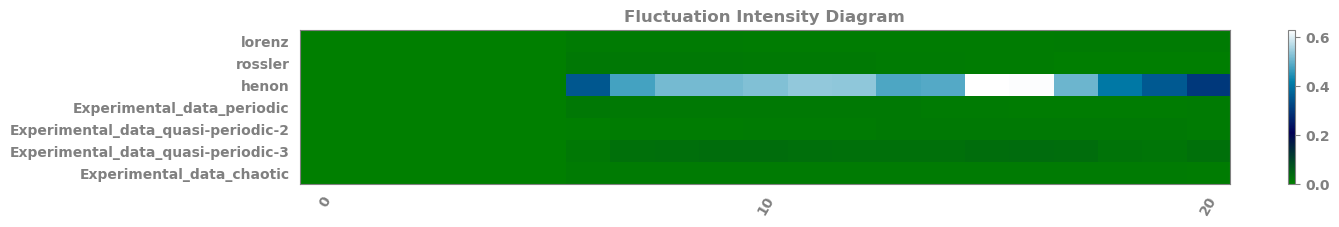

In [9]:
fluctuation_intensity_df = fluctuation_intensity(ts_df.pipe(apply_scaling), 
                                                              win=7, 
                                                              xmin=0, 
                                                              xmax=1, 
                                                              col_first=1, 
                                                              col_last=7)
_ = complexity_resonance_diagram(fluctuation_intensity_df,
                                plot_title='Fluctuation Intensity Diagram',
                                 cmap_n=2,
                                figsize=(15, 2))

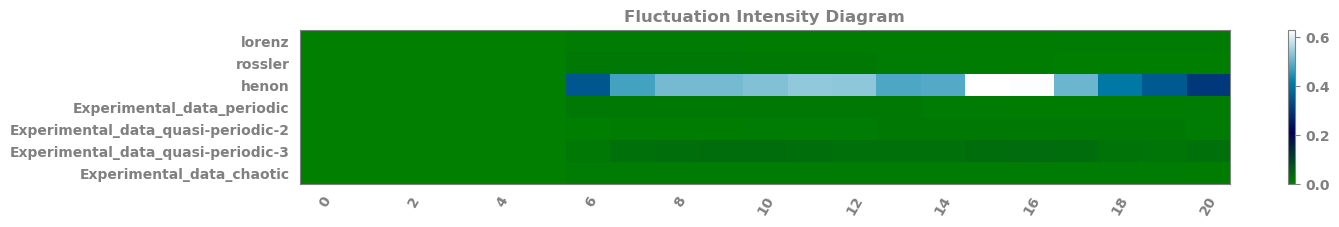

In [10]:
fluctuation_intensity_df = fluctuation_intensity_tmp(ts_df.pipe(apply_scaling), 
                                                              win=7, 
                                                              xmin=0, 
                                                              xmax=1, 
                                                              col_first=0, 
                                                              col_last=7)
_ = complexity_resonance_diagram(fluctuation_intensity_df,
                                plot_title='Fluctuation Intensity Diagram',
                                 labels_n=2,
                                 cmap_n=2,
                                figsize=(15, 2))

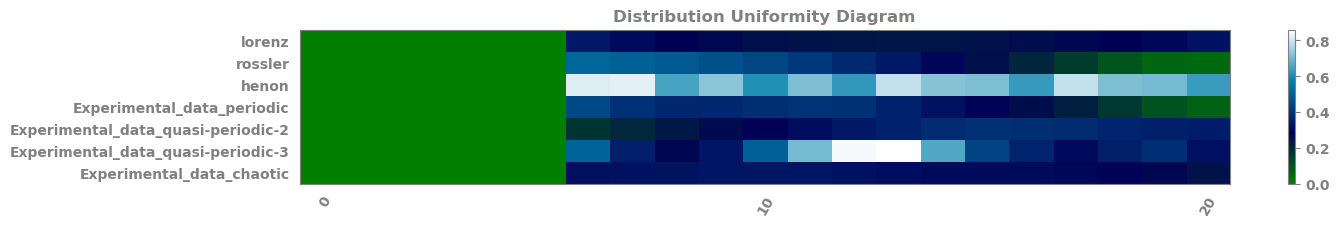

In [11]:
distribution_uniformity_df = distribution_uniformity(df=ts_df.pipe(apply_scaling), 
                                                      win=7, 
                                                      xmin=0, 
                                                      xmax=1, 
                                                      col_first=1, 
                                                      col_last=7)
                                         
_ = complexity_resonance_diagram(distribution_uniformity_df,
                                plot_title='Distribution Uniformity Diagram',
                                cmap_n=2,
                                figsize=(15, 2))

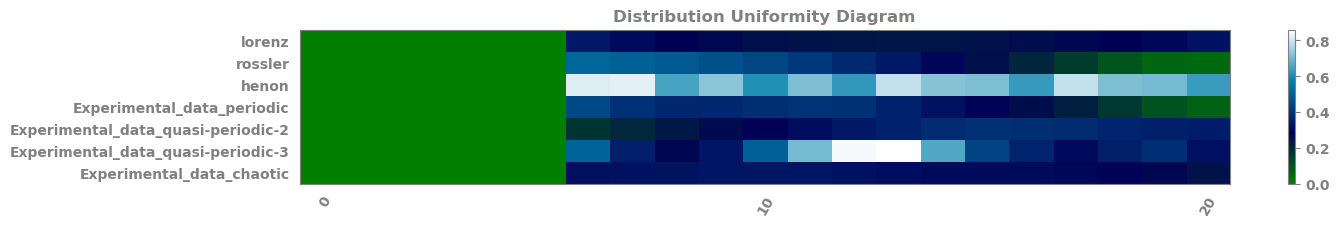

In [12]:
distribution_uniformity_df = distribution_uniformity_tmp(df=ts_df.pipe(apply_scaling), 
                                                      win=7, 
                                                      xmin=0, 
                                                      xmax=1, 
                                                      col_first=0, 
                                                      col_last=7)
                                         
_ = complexity_resonance_diagram(distribution_uniformity_df,
                                plot_title='Distribution Uniformity Diagram',
                                cmap_n=2,
                                figsize=(15, 2))

The Fluctuation Intensity is a measure sensitive to the amplitude and frequency of changes which occur in the time series $\mathbf{x} \in \Re^{\mathrm{N}}$ and is given by: 

\begin{equation}\label{eq:F}
\mathrm{F}\left(\mathbf{x}, m_{w}\right)= \frac{1}{(x_{\mathrm{M}} - x_{\mathrm{m}}) \, (m_{w}-1)} \sum_{k=1}^{m_{w}-1} \frac{ | x_{k+1} - x_{k} | }{n_{k+1}-n_{k}}, \, \, \mathrm{F} \in \left[0, 1\right]
\end{equation}

where the index $k$ refers to the $\textit{points of return}$, specifically, the number of changes in slope of the time series, whereas $x_{\mathrm{M}}$ and $x_{\mathrm{m}}$ denote the maximum and minimum value of $\mathbf{x}$, respectively. 

Conversely, the Distribution Uniformity $\mathrm{D}$ quantifies the irregularities of $\mathbf{x}$ by comparing it with an ideal distribution produced by another time series $\mathbf{y}$ with equal number of time points $\mathrm{N}$, and is defined as:  

\begin{equation}\label{eq:D}
\mathrm{D}\left(\mathbf{x},\mathbf{y}, m_{w}\right)=1-\sum_{c=1}^{m_{w}-1} \sum_{d=c+1}^{m_{w}} \sum_{a=c}^{d-1} \sum_{b=a+1}^{d} \frac{\Delta_{b a} \Theta\left(\Delta_{b a}\right)}{y_{b}-y_{a}}, \, \, \mathrm{D} \in \left[0, 1\right]
\end{equation}

with $\Delta_{b a} = \left(y_{b} - x_{b}\right) - \left(y_{a} - x_{a}\right)$ that quantifies the aberration of $\mathbf{x}$ with respect to $\mathbf{y}$, and $\Theta\left(\cdot \right)$ the Heaviside step function. The two outer sums are permutations of all combinations of $c$ and $d$ within the window, whereas the inner sums with index $a$ and $b$ are representing all combinations of positions within the interval given by $c$ and $d$.

In [13]:
ts = ts_df.pipe(apply_scaling).iloc[:, 0]

In [14]:
i = 1

In [15]:
win=7; xmin=0; xmax=1; col_first=1; col_last=7; df=ts_df

In [16]:
constant = 1 / ((xmax - xmin) * (win-1))
constant

0.16666666666666666

In [17]:
constant * sum(abs(ts.iloc[0: 7].values - ts.iloc[0+i: 7+i].values) / 6)

0.010786888632136345

In [18]:
fluctuation_intensity_df

,lorenz,rossler,henon,Experimental_data_periodic,Experimental_data_quasi-periodic-2,Experimental_data_quasi-periodic-3,Experimental_data_chaotic
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.009604,0.014362,0.351876,0.012697,0.004739,0.013468,0.008869
7,0.008736,0.013991,0.476617,0.011610,0.005595,0.025759,0.009228
8,0.008043,0.013547,0.515164,0.010876,0.006383,0.028729,0.009317
9,0.007508,0.012987,0.516572,0.010814,0.007283,0.030053,0.009114


In [19]:
nrow = len(df) + 2
ncol = col_last - col_first

ew_data_D = pd.DataFrame(np.zeros((nrow, ncol)))

for column in range(col_first, col_last):
    ts = df.iloc[:, column : column + 1].values
    y = np.linspace(xmin, xmax, win)

    for i in range(0, len(ts) - win + 1):
        x = ts[i : i + win]
        x = np.sort(x, axis=None)
        r = 0
        g = 0

        for e in range(0, win - 1):
            for d in range(e + 1, win):
                for a in range(e, d):
                    for b in range(a + 1, d + 1):
                        h = np.heaviside((y[b] - y[a]) - (x[b] - x[a]), 0)
                        if h == 1:
                            r += (y[b] - y[a]) - (x[b] - x[a])
                            g += y[b] - y[a]

        #print(r,g)
                            
        ew_data_D.iloc[i + win - 1, column - col_first] = 1.0 - r / g

#     distribution_uniformity_df = pd.DataFrame(ew_data_D.iloc[0 : len(df), :])

#     distribution_uniformity_df.columns = df.columns.tolist()
#     distribution_uniformity_df.index = df.index.tolist()

ZeroDivisionError: division by zero

In [ ]:
nrow = len(df) + 2
ncol = col_last - col_first

ew_data_D = pd.DataFrame(np.zeros((nrow, ncol)))

# reference series ("ideal distribution")
y = np.linspace(xmin, xmax, win)

for column in range(col_first, col_last):
    ts = df.iloc[:, column: column + 1].values

    for i in range(0, len(ts) - win + 1):
        x = ts[i : i + win]
        x = np.sort(x, axis=None)
        r = 0
        g = 0

        for e in range(0, win - 1):
            for d in range(e + 1, win):
                for a in range(e, d):
                    for b in range(a + 1, d + 1):
                        h = np.heaviside((y[b] - y[a]) - (x[b] - x[a]), 0)
                        if h == 1:
                            r += (y[b] - y[a]) - (x[b] - x[a])
                            g += y[b] - y[a]

        ew_data_D.iloc[i + win - 1, column - col_first] = 1.0 - r / g

In [ ]:
def mini_du(df: pd.DataFrame, 
                                win: int, 
                                xmin: int, 
                                xmax: int, 
                                col_first: int, 
                                col_last: int):

    nrow = len(df) + 2
    ncol = col_last - col_first
    
    ew_data_D = pd.DataFrame(np.zeros((nrow, ncol)))
    # reference series ("ideal distribution")
    y = np.linspace(xmin, xmax, win)

    for i in range(0, len(ts) - win + 1):
        x = ts[i : i + win]
        x = np.sort(x, axis=None)
        r = 0
        g = 0

        for e in range(0, win - 1):
            for d in range(e + 1, win):
                for a in range(e, d):
                    for b in range(a + 1, d + 1):
                        h = np.heaviside((y[b] - y[a]) - (x[b] - x[a]), 0)
                        if h == 1:
                            r += (y[b] - y[a]) - (x[b] - x[a])
                            g += y[b] - y[a]

#         ew_data_D.iloc[i + win - 1, column - col_first] = 1.0 - r / g
        
        if g==0:
            ew_data_D.iloc[i + win - 1, column - col_first] = 0
        else:
            ew_data_D.iloc[i + win - 1, column - col_first] = 1.0 - r / g

    distribution_uniformity_df = pd.DataFrame(ew_data_D.iloc[0 : len(df), :])

    distribution_uniformity_df.columns = df.columns.tolist()
    distribution_uniformity_df.index = df.index.tolist()

    return distribution_uniformity_df

In [ ]:
_ = complexity_resonance_diagram(ts_df.pipe(apply_scaling).pipe(mini_du, win=7, xmin=0, xmax=1, col_first=0, col_last=7),
                                plot_title='Distribution Uniformity Diagram',
                                cmap_n=2,
                                figsize=(15, 2))

In [ ]:
h